# Oil Price Prediction

This notebook loads a cleaned dataset and applies:
- Classic Machine Learning models (Linear Regression, Random Forest, etc.)
- Time Series forecasting using Prophet

to predict the future WTI Crude oil prices.

In [ ]:
# Cell 1: Import Required Libraries (Updated)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Time Series Libraries
from prophet import Prophet
import statsmodels.api as sm # ADDED for ARIMA/SARIMA

# Additional libraries
from tqdm import tqdm
import logging

# Suppress verbose informational messages from Prophet and its backend
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)


print("All libraries imported successfully!")


All libraries imported successfully!


In [ ]:
# Cell 2: Load and Examine the Dataset
file_path = '/content/relevant_features_1.csv'
df = pd.read_csv(file_path)

In [ ]:
# Cell 2a: Configuration for Time Granularity (Updated)
# Choose frequency: 'D' for Daily, 'W' for Weekly, 'M' for Monthly
resample_frequency = 'M' # <-- CHANGE THIS to 'D', 'W', or 'M'

# Adjust parameters based on the chosen frequency
if resample_frequency == 'D':
    freq_str = 'Day'
    lags = [1, 2, 3, 5, 7, 14]
    window_sizes = [5, 10, 20]
    initial_train_periods = 500 # Approx 2 years of daily data
    test_periods = 200          # Approx 9-10 months
    forecast_periods = 90       # 3 months
    seasonal_period = 7         # Weekly seasonality for daily data
elif resample_frequency == 'W':
    freq_str = 'Week'
    lags = [1, 2, 3, 4]          # 1 to 4 weeks
    window_sizes = [4, 8, 12]    # Approx 1, 2, 3 months
    initial_train_periods = 104  # 2 years of weekly data
    test_periods = 52            # 1 year
    forecast_periods = 12        # Approx 3 months
    seasonal_period = 52         # Yearly seasonality for weekly data
elif resample_frequency == 'M':
    freq_str = 'Month'
    lags = [1, 2, 3, 6]          # 1 to 6 months
    window_sizes = [3, 6, 12]    # Quarter, Half-year, Year
    initial_train_periods = 36   # 3 years of monthly data
    test_periods = 24            # 2 years
    forecast_periods = 6         # 6 months
    seasonal_period = 12         # Yearly seasonality for monthly data
else:
    raise ValueError("resample_frequency must be 'D', 'W', or 'M'")

print(f"✅ Configuration set for {freq_str}ly frequency.")
print(f"   - Lags: {lags}")
print(f"   - Windows: {window_sizes}")
print(f"   - Test Periods: {test_periods}")
print(f"   - Forecast Periods: {forecast_periods}")
print(f"   - SARIMA Seasonal Period: {seasonal_period}")

✅ Configuration set for Monthly frequency.
   - Lags: [1, 2, 3, 6]
   - Windows: [3, 6, 12]
   - Test Periods: 24
   - Forecast Periods: 6
   - SARIMA Seasonal Period: 12


In [ ]:
# Cell 3: Data Preprocessing (Updated for Resampling)
date_col = 'Date' if 'Date' in df.columns else 'date'
df[date_col] = pd.to_datetime(df[date_col])
df = df.sort_values(date_col).set_index(date_col) # Set date as index for resampling

# Resample the data to the desired frequency using the mean to aggregate
df = df.resample(resample_frequency).mean()

# Forward-fill any missing values that might result from resampling
df = df.ffill().reset_index()

print(f"\nData preprocessed and resampled to {freq_str}ly frequency.")
df.head()


Data preprocessed and resampled to Monthly frequency.


,Date,WTI_Crude,RBOB_Gasoline,Heating_Oil,Copper,Brent_Oil,CAD_USD,Silver,Energy_ETF,DXY,Emerging_Markets,Gold,NOK_USD,EUR_USD,FTSE100,Materials
0,2000-01-31,32.049999,0.884,0.9764,0.885,75.739998,0.731689,4.93,14.214703,101.712858,7.340263,273.899994,0.106793,1.196501,6480.857143,14.457459
1,2000-02-29,32.049999,0.884,0.9764,0.885,75.739998,0.731689,4.93,13.512289,104.433333,7.340263,273.899994,0.106793,1.196501,6178.509510,12.628847
2,2000-03-31,32.049999,0.884,0.9764,0.885,75.739998,0.731689,4.93,14.373834,105.543478,7.340263,273.899994,0.106793,1.196501,6541.465247,12.177692
3,2000-04-30,32.049999,0.884,0.9764,0.885,75.739998,0.731689,4.93,14.866451,106.798999,7.340263,273.899994,0.106793,1.196501,6305.560010,12.992805
4,2000-05-31,32.049999,0.884,0.9764,0.885,75.739998,0.731689,4.93,15.945073,110.713478,7.340263,273.899994,0.106793,1.196501,6215.639096,12.838598


In [ ]:
# Cell 4: Feature Engineering Functions (CORRECTED to prevent leakage)

def create_technical_features(data, target_col='WTI_Crude', window_sizes=[5, 10, 20]):
    """
    CORRECTED: Calculates technical features using only past data to prevent leakage.
    We .shift(1) to ensure the current period's value is not included in the calculation.
    """
    data = data.copy()
    for window in window_sizes:
        # The .shift(1) here is the crucial fix
        data[f'{target_col}_MA_{window}'] = data[target_col].shift(1).rolling(window=window).mean()
        data[f'{target_col}_Vol_{window}'] = data[target_col].shift(1).rolling(window=window).std()
    return data

# The other functions in this cell are correct and do not need to be changed.
def create_lag_features(data, target_col='WTI_Crude', other_features=None, lags=[1, 2, 3, 5, 7]):
    data = data.copy()
    for lag in lags:
        data[f'{target_col}_lag_{lag}'] = data[target_col].shift(lag)
    if other_features is not None:
        for feature in other_features:
            if feature in data.columns:
                for lag in lags[:3]:
                    data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)
    return data

def create_time_features(data, date_col):
    data = data.copy()
    data['year'] = data[date_col].dt.year
    data['month'] = data[date_col].dt.month
    data['day_of_year'] = data[date_col].dt.dayofyear
    data['weekday'] = data[date_col].dt.dayofweek
    return data

In [ ]:
# Cell 5: Realistic Backtesting Framework (Updated for Different Frequencies & Models)
class RealisticModelBacktester:
    def __init__(self, data, target_col='WTI_Crude', date_col='Date'):
        self.data = data.copy()
        self.target_col = target_col
        self.date_col = date_col
        self.results = {}

    # Pass the globally defined lags and window_sizes
    def prepare_features_historical_only(self, data, p_lags, p_window_sizes):
        data = create_time_features(data, self.date_col)
        # Use the passed parameters for feature creation
        data = create_technical_features(data, self.target_col, window_sizes=p_window_sizes)
        other_features = ['DXY', 'Gold', 'EUR_USD', 'Brent_Oil', 'RBOB_Gasoline', 'Heating_Oil']
        # Use the passed parameters for lag creation
        data = create_lag_features(data, self.target_col, other_features, lags=p_lags)
        return data

    def get_feature_columns(self, data):
        exclude_cols = [self.target_col, self.date_col]
        current_day_features = ['DXY', 'Gold', 'EUR_USD', 'Brent_Oil', 'RBOB_Gasoline',
                                'Heating_Oil', 'Energy_ETF', 'Emerging_Markets', 'FTSE100',
                                'Materials', 'CAD_USD', 'NOK_USD', 'Silver', 'Copper']
        exclude_cols.extend(current_day_features)
        feature_cols = [col for col in data.columns if col not in exclude_cols and pd.api.types.is_numeric_dtype(data[col])]
        return feature_cols

    # Function now takes parameters for periods, lags, and windows
    def walk_forward_validation_realistic(self, initial_train_periods, total_test_periods, p_lags, p_window_sizes):
        print(f"Starting realistic walk-forward validation for {total_test_periods} periods...")
        models = {
            'Linear Regression': LinearRegression(),
            'Ridge Regression': Ridge(alpha=1.0),
            'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=50, random_state=42),
            'Prophet': 'prophet_placeholder', # Placeholder, logic handled in loop
            'ARIMA': 'arima_placeholder',     # Placeholder for ARIMAX
            'SARIMA': 'sarima_placeholder'    # Placeholder for SARIMAX
        }
        all_predictions = {name: [] for name in models.keys()}
        all_actuals, all_dates = [], []
        start_idx = initial_train_periods

        # Define model orders here for clarity
        arima_order = (5, 1, 1) # (p,d,q)
        sarima_order = (2, 1, 2) # (p,d,q)
        sarima_seasonal_order = (1, 1, 0, seasonal_period) # (P,D,Q,s)

        for i in tqdm(range(total_test_periods), desc="Backtesting"):
            if start_idx + 1 > len(self.data): break
            train_end_idx = start_idx
            test_end_idx = start_idx + 1
            # Pass lags and windows to the feature preparation step
            full_featured_data = self.prepare_features_historical_only(self.data.iloc[:test_end_idx], p_lags, p_window_sizes)
            train_features = full_featured_data.iloc[:train_end_idx].dropna()
            test_features_row = full_featured_data.iloc[start_idx:test_end_idx]

            if len(train_features) < 20: # Reduced threshold for lower frequency data
                start_idx += 1
                continue

            feature_cols = self.get_feature_columns(train_features)
            # Ensure consistent feature order for all models
            X_train = train_features[feature_cols].ffill().bfill()
            y_train = train_features[self.target_col]
            X_test = test_features_row[feature_cols].ffill().bfill() # ffill then bfill to be safe
            y_actual = self.data.iloc[start_idx:test_end_idx][self.target_col].iloc[0]

            for name, model in models.items():
                try:
                    if name == 'Prophet':
                        m = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
                        prophet_train_df = train_features[[self.date_col, self.target_col] + feature_cols].rename(columns={self.date_col: 'ds', self.target_col: 'y'})
                        for col in feature_cols: m.add_regressor(col)
                        m.fit(prophet_train_df)
                        future_df = test_features_row[[self.date_col] + feature_cols].rename(columns={self.date_col: 'ds'})
                        future_df[feature_cols] = future_df[feature_cols].ffill().bfill() # Ensure no NaNs in regressors
                        forecast = m.predict(future_df)
                        prediction = forecast['yhat'].iloc[0]

                    elif name == 'ARIMA':
                        mod = sm.tsa.statespace.sarimax.SARIMAX(y_train, exog=X_train,
                                                               order=arima_order,
                                                               enforce_stationarity=False,
                                                               enforce_invertibility=False)
                        res = mod.fit(disp=False)
                        prediction = res.forecast(steps=1, exog=X_test).iloc[0]

                    elif name == 'SARIMA':
                        mod = sm.tsa.statespace.sarimax.SARIMAX(y_train, exog=X_train,
                                                               order=sarima_order,
                                                               seasonal_order=sarima_seasonal_order,
                                                               enforce_stationarity=False,
                                                               enforce_invertibility=False)
                        res = mod.fit(disp=False)
                        prediction = res.forecast(steps=1, exog=X_test).iloc[0]

                    else: # Handle sklearn models
                        model.fit(X_train, y_train)
                        prediction = model.predict(X_test)[0]

                    all_predictions[name].append(prediction)
                except Exception as e:
                    # print(f"Warning: Model {name} failed at step {i}. Error: {e}")
                    all_predictions[name].append(np.nan)

            all_actuals.append(y_actual)
            all_dates.append(self.data.iloc[start_idx:test_end_idx][self.date_col].iloc[0])
            start_idx += 1

        results_df = pd.DataFrame({'Date': all_dates, 'Actual': all_actuals, **all_predictions})
        self.results = results_df
        return self.results

    def calculate_metrics(self):
        metrics = {}
        for col in self.results.columns:
            if col not in ['Date', 'Actual']:
                temp_df = pd.DataFrame({
                    'Actual': self.results['Actual'],
                    'Predictions': self.results[col]
                }).dropna()

                if len(temp_df) < 2:
                    print(f"Skipping metrics for {col} due to insufficient valid data.")
                    continue

                actual = temp_df['Actual']
                predictions = temp_df['Predictions']

                mae = mean_absolute_error(actual, predictions)
                r2 = r2_score(actual, predictions)
                actual_dir = np.diff(actual) > 0
                pred_dir = np.diff(predictions) > 0
                dir_acc = np.mean(actual_dir == pred_dir) * 100
                metrics[col] = {'MAE': mae, 'R²': r2, 'Directional_Accuracy': dir_acc}
        return pd.DataFrame(metrics).T

In [ ]:
# Cell 6 & 7: Run Backtesting and Analyze Results (Updated)
backtester = RealisticModelBacktester(df)

# Use the globally defined parameters from Cell 2a
backtest_results = backtester.walk_forward_validation_realistic(
    initial_train_periods=initial_train_periods,
    total_test_periods=test_periods,
    p_lags=lags,
    p_window_sizes=window_sizes
)

print(f"\nCalculating realistic performance metrics for all models ({freq_str}ly)...")
performance_metrics = backtester.calculate_metrics()
print(f"\nREALISTIC BACKTESTING PERFORMANCE METRICS ({freq_str.upper()}LY)")
print("="*70)
print(performance_metrics.round(4))
print("="*70)

print("Backtest evaluation complete. Moving to future forecasting...")

Starting realistic walk-forward validation for 24 periods...


Backtesting:   0%|          | 0/24 [00:00<?, ?it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpikwk7jj8/ma7_a7ry.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpikwk7jj8/2dc4bbss.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7731', 'data', 'file=/tmp/tmpikwk7jj8/ma7_a7ry.json', 'init=/tmp/tmpikwk7jj8/2dc4bbss.json', 'output', 'file=/tmp/tmpikwk7jj8/prophet_modellmmg06_d/prophet_model-20250813202042.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:20:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:20:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Backtesting:   4%|▍         | 1/24 [00:03<01:27,  3.80s/it]DEBUG:cmdstanpy:input tempfile: /tmp/tmpikwk7jj8/m95gds96.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpikwk7jj8/5veeorom.json
DEBUG:


Calculating realistic performance metrics for all models (Monthly)...
Skipping metrics for ARIMA due to insufficient valid data.
Skipping metrics for SARIMA due to insufficient valid data.

REALISTIC BACKTESTING PERFORMANCE METRICS (MONTHLY)
                        MAE         R²  Directional_Accuracy
Linear Regression    6.8026    -0.8917               43.4783
Ridge Regression     3.6982     0.5473               43.4783
Random Forest        2.9923     0.6648               60.8696
Gradient Boosting    2.9448     0.7052               69.5652
Prophet            170.1730 -1355.2210               52.1739
Backtest evaluation complete. Moving to future forecasting...



✅ Selected best model based on R²: Gradient Boosting
Preparing full dataset features for final model training...
Training on data up to: 2025-08-31
Re-training Gradient Boosting on the full historical dataset...
Model re-training complete.
Generating forecast for the next 6 Months...


Forecasting: 100%|██████████| 6/6 [00:00<00:00, 31.47it/s]


Visualizing historical data and future forecast...


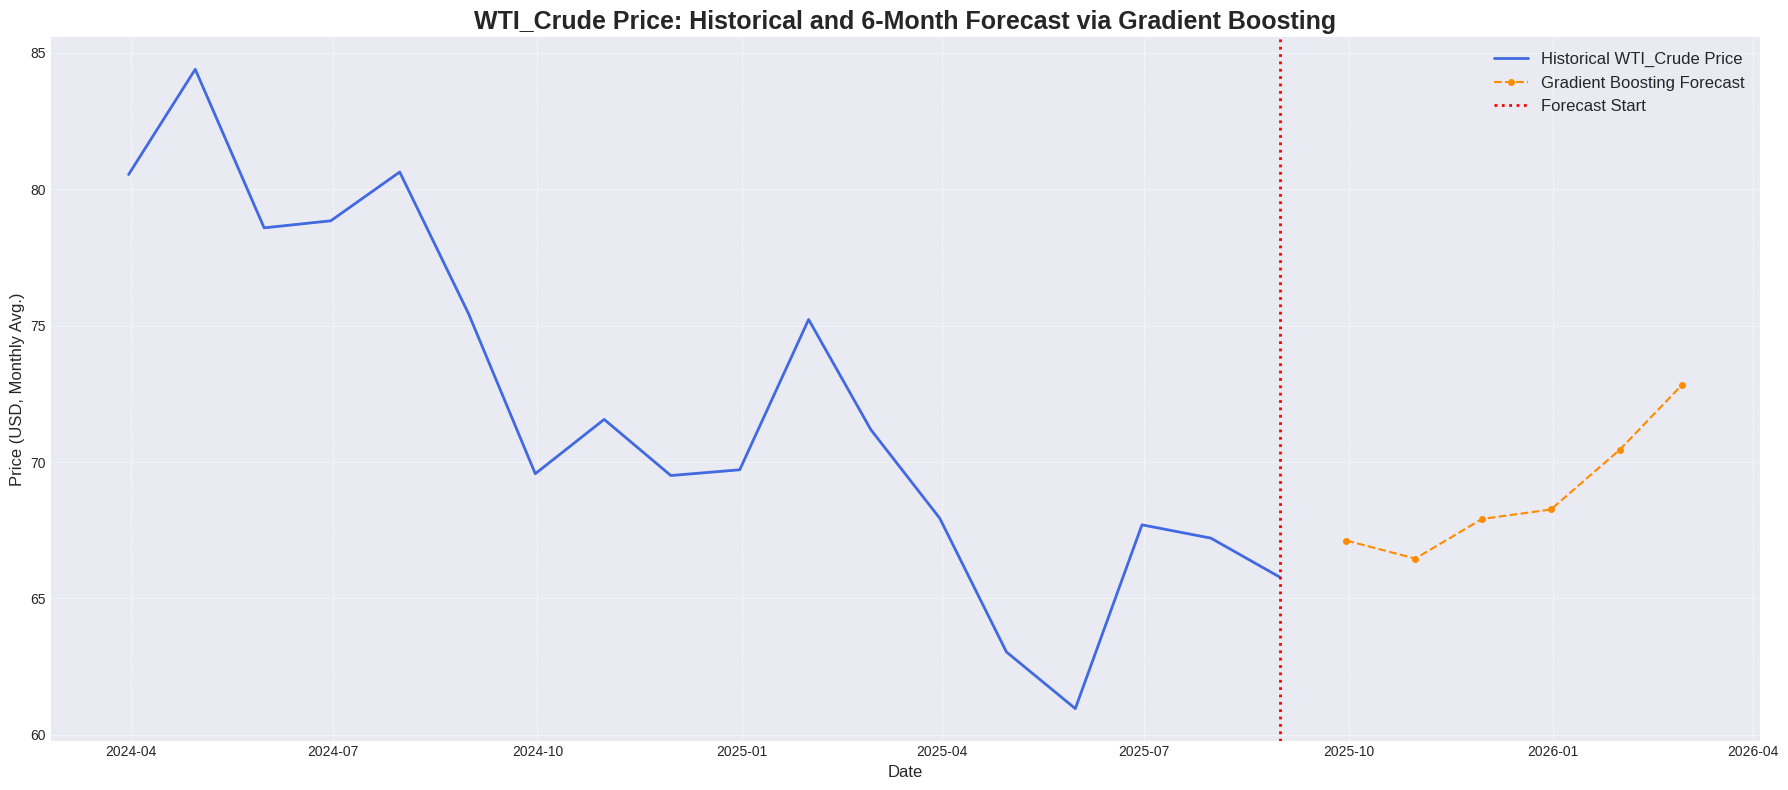

In [ ]:
# Cell 8: Future Forecasting & Visualization (Updated for Different Frequencies)

# The `freq` parameter is new ('D', 'W', 'M')
# CELL 8: CORRECTED a portion of the code

def forecast_future(model, full_data, last_known_data, n_periods, freq, target_col='WTI_Crude', date_col='Date'):
    """
    Generates a true iterative forecast for n_periods into the future.
    """
    print(f"Generating forecast for the next {n_periods} {freq_str}s...")

    # Get feature engineering params from global scope
    p_lags = lags
    p_window_sizes = window_sizes

    # Identify feature columns from the training data
    exclude_cols = [target_col, date_col]
    current_day_features = ['DXY', 'Gold', 'EUR_USD', 'Brent_Oil', 'RBOB_Gasoline',
                            'Heating_Oil', 'Energy_ETF', 'Emerging_Markets', 'FTSE100',
                            'Materials', 'CAD_USD', 'NOK_USD', 'Silver', 'Copper']
    exclude_cols.extend(current_day_features)
    feature_cols = [col for col in full_data.columns if col not in exclude_cols and pd.api.types.is_numeric_dtype(full_data[col])]

    future_data = last_known_data.copy()
    predictions = []
    last_date = future_data[date_col].max()

    original_exo_cols = [col for col in current_day_features if col in future_data.columns]

    # Use pd.DateOffset for robust date arithmetic
    freq_map = {'D': 'days', 'W': 'weeks', 'M': 'months'}
    offset_kwarg = {freq_map[freq]: 1}

    for i in tqdm(range(n_periods), desc="Forecasting"):
        data_for_features = future_data.copy()

        # Apply all feature engineering functions
        data_for_features = create_time_features(data_for_features, date_col)
        data_for_features = create_technical_features(data_for_features, target_col, window_sizes=p_window_sizes)

        # --- THIS IS THE FIX ---
        # Instead of creating lags for ALL columns, we now explicitly create lags
        # for the target variable and the original exogenous variables, matching
        # the features the model was trained on.
        data_for_features = create_lag_features(data_for_features, target_col, original_exo_cols, lags=p_lags)

        features_for_prediction = data_for_features.iloc[-1:]
        X_future = features_for_prediction[feature_cols].ffill()

        if X_future.isnull().values.any():
            last_historical_features = full_data[feature_cols].iloc[-1]
            X_future = X_future.fillna(last_historical_features)

        prediction = model.predict(X_future)[0]
        predictions.append(prediction)

        # Create the next row using the calculated date offset
        next_date = last_date + pd.DateOffset(**{freq_map[freq]: i + 1})
        new_row = {date_col: next_date, target_col: prediction}

        last_values = future_data.iloc[-1]
        for col in original_exo_cols:
            new_row[col] = last_values[col] # Assumes exogenous features are constant

        future_data = pd.concat([future_data, pd.DataFrame([new_row])], ignore_index=True)

    forecast_df = pd.DataFrame({
        date_col: pd.to_datetime([last_date + pd.DateOffset(**{freq_map[freq]: i + 1}) for i in range(n_periods)]),
        'Forecast': predictions
    })

    return forecast_df


# --- Main Execution ---

# Cell 8: Future Forecasting & Visualization (Updated for All Models)

# --- Main Execution ---

if not performance_metrics.empty and 'R²' in performance_metrics.columns:
    # Find the model with the highest directional accuracy, ignoring any with all NaN results
    best_model_name = performance_metrics.dropna()['R²'].idxmax()
    print(f"\n✅ Selected best model based on R²: {best_model_name}")

    target_col = backtester.target_col
    date_col = backtester.date_col
    future_predictions_df = None # Initialize forecast dataframe

    # Prepare full dataset and features once
    print("Preparing full dataset features for final model training...")
    full_featured_data = backtester.prepare_features_historical_only(df, lags, window_sizes).dropna()
    feature_cols = backtester.get_feature_columns(full_featured_data)
    X_full = full_featured_data[feature_cols]
    y_full = full_featured_data[target_col]
    print(f"Training on data up to: {full_featured_data[date_col].max().strftime('%Y-%m-%d')}")

    # --- Model-Specific Forecasting Logic ---
    if best_model_name == 'Prophet':
        print(f"Re-training {best_model_name} on the full historical dataset...")
        final_model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
        prophet_full_df = full_featured_data[[date_col, target_col] + feature_cols].rename(columns={date_col: 'ds', target_col: 'y'})
        for col in feature_cols:
            final_model.add_regressor(col)
        final_model.fit(prophet_full_df)

        print(f"Generating forecast for the next {forecast_periods} {freq_str}s...")
        future_dates = final_model.make_future_dataframe(periods=forecast_periods, freq=resample_frequency)
        # For future regressors, we assume they hold their last known value
        last_known_regressors = X_full.iloc[-1:].to_dict(orient='records')[0]
        for col, val in last_known_regressors.items():
            future_dates[col] = val

        forecast = final_model.predict(future_dates.tail(forecast_periods))
        future_predictions_df = forecast[['ds', 'yhat']].rename(columns={'ds': date_col, 'yhat': 'Forecast'})

    elif best_model_name in ['ARIMA', 'SARIMA']:
        print(f"Re-training {best_model_name} on the full historical dataset...")
        order = (5, 1, 1) # p, d, q
        seasonal_order = (1, 1, 0, seasonal_period) if best_model_name == 'SARIMA' else (0, 0, 0, 0)

        final_model = sm.tsa.statespace.sarimax.SARIMAX(y_full, exog=X_full,
                                                       order=order, seasonal_order=seasonal_order,
                                                       enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        print("Model re-training complete.")

        print(f"Generating forecast for the next {forecast_periods} {freq_str}s...")
        # For future exogenous variables, we carry forward the last known values
        future_exog = pd.DataFrame([X_full.iloc[-1]] * forecast_periods)
        future_exog.index = pd.date_range(start=df[date_col].max() + pd.Timedelta(days=1), periods=forecast_periods, freq=resample_frequency)

        forecast = final_model.forecast(steps=forecast_periods, exog=future_exog)
        future_predictions_df = forecast.to_frame(name='Forecast').reset_index().rename(columns={'index': date_col})

    else: # Handles all sklearn models
        print(f"Re-training {best_model_name} on the full historical dataset...")
        models = {
            'Linear Regression': LinearRegression(),
            'Ridge Regression': Ridge(alpha=1.0),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
        }
        final_model = models[best_model_name]
        final_model.fit(X_full, y_full)
        print("Model re-training complete.")
        # Use the original iterative forecast function for sklearn models
        max_feature_period = max(max(lags), max(window_sizes))
        last_known_data = df.iloc[-max_feature_period:].copy()
        future_predictions_df = forecast_future(final_model, full_featured_data, last_known_data, n_periods=forecast_periods, freq=resample_frequency)


    # --- Universal Visualization ---
    if future_predictions_df is not None:
        print("\nVisualizing historical data and future forecast...")
        plt.style.use('seaborn-v0_8-darkgrid')
        plt.figure(figsize=(18, 8))

        historical_plot_periods = forecast_periods * 3
        historical_plot_data = df.iloc[-historical_plot_periods:]
        plt.plot(historical_plot_data[date_col], historical_plot_data[target_col], label=f'Historical {target_col} Price', color='royalblue', linewidth=2)

        plt.plot(future_predictions_df[date_col], future_predictions_df['Forecast'], label=f'{best_model_name} Forecast', color='darkorange', linestyle='--', marker='o', markersize=4)
        plt.axvline(df[date_col].max(), color='red', linestyle=':', linewidth=2, label='Forecast Start')

        plt.title(f'{target_col} Price: Historical and {forecast_periods}-{freq_str} Forecast via {best_model_name}', fontsize=18, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel(f'Price (USD, {freq_str}ly Avg.)', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Could not generate a forecast for the selected model: {best_model_name}")

else:
    print("Performance metrics not available. Cannot determine the best model for forecasting.")

# Task
Generate a single CSV file containing historical crude oil prices, backtesting results for all models (excluding ARIMA and SARIMA), and future forecasts for all models (excluding ARIMA and SARIMA). The CSV should have columns for 'Date', 'DataType' (indicating 'Actual', 'Backtest', or 'Forecast'), 'Model' (indicating the model used), and 'Value' (the price). Explain how this CSV structure facilitates creating a Power BI report with slicers for data type and model.

## Generate forecasts for all models

### Subtask:
Generate future forecasts for each model that was included in the backtesting (excluding ARIMA and SARIMA).


**Reasoning**:
Iterate through the selected models, re-train them on the full dataset, and generate future forecasts for each, storing the results in a dictionary.



In [ ]:
# Step 2: Initialize dictionary to store future forecasts
future_forecasts_all_models = {}

# Step 1: Define models for forecasting (excluding ARIMA and SARIMA)
models_to_forecast = [name for name in models_for_export.keys() if name not in ['ARIMA', 'SARIMA']]

# Prepare full dataset and features once for final model training
print("Preparing full dataset features for final model training for all selected models...")
# Use the original df and global lags/windows
full_featured_data_export_final = backtester.prepare_features_historical_only(df, lags, window_sizes).dropna()
feature_cols_export_final = backtester.get_feature_columns(full_featured_data_export_final)
X_full_export_final = full_featured_data_export_final[feature_cols_export_final]
y_full_export_final = full_featured_data_export_final[target_col] # Use target_col
print(f"Training on data up to: {full_featured_data_export_final[date_col].max().strftime('%Y-%m-%d')}") # Use date_col


# Step 3 & 4: Iterate through models and generate forecasts
for model_name in models_to_forecast:
    print(f"\nGenerating future forecast for: {model_name}")

    try:
        if model_name == 'Prophet':
            # Step 6: Handle Prophet forecasting
            print(f"Re-training {model_name} on the full historical dataset...")
            final_model_export = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
            prophet_full_df_export = full_featured_data_export_final[[date_col, target_col] + feature_cols_export_final].rename(columns={date_col: 'ds', target_col: 'y'}) # Use date_col and target_col
            for col in feature_cols_export_final:
                final_model_export.add_regressor(col)
            final_model_export.fit(prophet_full_df_export)

            print(f"Generating forecast for the next {forecast_periods} {freq_str}s...") # Use freq_str
            future_dates_export = final_model_export.make_future_dataframe(periods=forecast_periods, freq=resample_frequency) # Use resample_frequency
            # For future regressors, we assume they hold their last known value
            last_known_regressors_export = X_full_export_final.iloc[-1:].to_dict(orient='records')[0]
            for col, val in last_known_regressors_export.items():
                future_dates_export[col] = val

            forecast_export_final = final_model_export.predict(future_dates_export.tail(forecast_periods))
            future_predictions_df = forecast_export_final[['ds', 'yhat']].rename(columns={'ds': date_col, 'yhat': 'Forecast'}) # Use date_col
            future_forecasts_all_models[model_name] = future_predictions_df

        else:
            # Step 5: Handle sklearn model forecasting
            print(f"Re-training {model_name} on the full historical dataset...")
            models_export_final = {
                'Linear Regression': LinearRegression(),
                'Ridge Regression': Ridge(alpha=1.0),
                'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
                'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
            }
            final_model_export = models_export_final[model_name]
            final_model_export.fit(X_full_export_final, y_full_export_final)
            print("Model re-training complete.")
            # Use the original iterative forecast function for sklearn models
            max_feature_period_export = max(max(lags), max(window_sizes)) # Use global lags and window_sizes
            last_known_data_export = df.iloc[-max_feature_period_export:].copy() # Use original df
            future_predictions_df = forecast_future(final_model_export, full_featured_data_export_final, last_known_data_export, n_periods=forecast_periods, freq=resample_frequency, target_col=target_col, date_col=date_col) # Use global parameters and original df
            future_forecasts_all_models[model_name] = future_predictions_df

    except Exception as e:
        print(f"Error generating forecast for {model_name}: {e}")
        future_forecasts_all_models[model_name] = pd.DataFrame({date_col: [], 'Forecast': []}) # Store empty DataFrame on failure

print("\n✅ Future forecasts generated for all selected models.")

Preparing full dataset features for final model training for all selected models...
Training on data up to: 2025-08-31

Generating future forecast for: Linear Regression
Re-training Linear Regression on the full historical dataset...
Model re-training complete.
Generating forecast for the next 6 Months...


Forecasting: 100%|██████████| 6/6 [00:00<00:00, 28.68it/s]



Generating future forecast for: Ridge Regression
Re-training Ridge Regression on the full historical dataset...
Model re-training complete.
Generating forecast for the next 6 Months...


Forecasting: 100%|██████████| 6/6 [00:00<00:00, 31.40it/s]



Generating future forecast for: Random Forest
Re-training Random Forest on the full historical dataset...
Model re-training complete.
Generating forecast for the next 6 Months...


Forecasting: 100%|██████████| 6/6 [00:00<00:00,  9.09it/s]



Generating future forecast for: Gradient Boosting
Re-training Gradient Boosting on the full historical dataset...
Model re-training complete.
Generating forecast for the next 6 Months...


Forecasting: 100%|██████████| 6/6 [00:00<00:00, 25.39it/s]
DEBUG:cmdstanpy:input tempfile: /tmp/tmpikwk7jj8/6_838lmw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpikwk7jj8/_xppzog7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35763', 'data', 'file=/tmp/tmpikwk7jj8/6_838lmw.json', 'init=/tmp/tmpikwk7jj8/_xppzog7.json', 'output', 'file=/tmp/tmpikwk7jj8/prophet_modelkid5guwx/prophet_model-20250813202659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



Generating future forecast for: Prophet
Re-training Prophet on the full historical dataset...


20:26:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Generating forecast for the next 6 Months...

✅ Future forecasts generated for all selected models.


## Structure data for power bi (revised)

### Subtask:
Combine historical actuals, backtest predictions for all models, and future forecasts for all models into a single DataFrame with 'Date', 'DataType', 'Model', and 'Value' columns.


**Reasoning**:
Combine the historical actuals, backtest predictions, and future forecasts into a single DataFrame for export, following the specified structure.



In [ ]:
# Define backtest_results_export by assigning the results from the previous backtesting run
# This assumes the backtesting in Cell _yeJvqgjJDVx was run successfully and backtest_results is available.
backtest_results_export = backtest_results.copy()

print("✅ backtest_results_export defined from previous backtesting results.")

In [ ]:
# Step 1: Create a DataFrame for historical actual prices
historical_data_export = df[[date_col, target_col]].copy()
historical_data_export['DataType'] = 'Historical Actual'
historical_data_export['Model'] = 'Actual'
historical_data_export['Value'] = historical_data_export[target_col]
historical_data_export = historical_data_export[[date_col, 'DataType', 'Model', 'Value']]

# Step 2: Melt the backtest_results_export DataFrame
backtest_melted = backtest_results_export.melt(id_vars=[date_col, 'Actual'], var_name='Model', value_name='Value')
backtest_melted['DataType'] = 'Backtest Prediction'
backtest_melted = backtest_melted[[date_col, 'DataType', 'Model', 'Value']].dropna()

# Step 3: Create a list to hold the structured future forecast DataFrames
structured_future_forecasts = []
for model_name, forecast_df in future_forecasts_all_models.items():
    if not forecast_df.empty:
        forecast_df_structured = forecast_df.copy()
        forecast_df_structured['DataType'] = 'Future Forecast'
        forecast_df_structured['Model'] = model_name
        forecast_df_structured = forecast_df_structured.rename(columns={'Forecast': 'Value'})
        structured_future_forecasts.append(forecast_df_structured[[date_col, 'DataType', 'Model', 'Value']].dropna())

# Step 4: Concatenate all dataframes
if structured_future_forecasts:
    combined_data_export = pd.concat([historical_data_export, backtest_melted] + structured_future_forecasts, ignore_index=True)
else:
    combined_data_export = pd.concat([historical_data_export, backtest_melted], ignore_index=True)
    print("No future forecast data available for combining.")

# Step 5: Drop any rows with missing 'Value' (already handled by .dropna() in steps 2 and 3)
# This step is implicitly covered by the .dropna() calls above, but we can re-apply if needed
combined_data_export.dropna(subset=['Value'], inplace=True)


# Step 6: Store the resulting combined DataFrame (already done in step 4)
display(combined_data_export.head())
display(combined_data_export.tail())

,Date,DataType,Model,Value
0,2000-01-31,Historical Actual,Actual,32.049999
1,2000-02-29,Historical Actual,Actual,32.049999
2,2000-03-31,Historical Actual,Actual,32.049999
3,2000-04-30,Historical Actual,Actual,32.049999
4,2000-05-31,Historical Actual,Actual,32.049999


,Date,DataType,Model,Value
453,2025-10-31,Future Forecast,Prophet,74.550827
454,2025-11-30,Future Forecast,Prophet,74.363275
455,2025-12-31,Future Forecast,Prophet,77.056468
456,2026-01-31,Future Forecast,Prophet,67.854333
457,2026-02-28,Future Forecast,Prophet,68.303535


## Export to csv (revised)

### Subtask:
Save the combined DataFrame to a CSV file.


**Reasoning**:
Save the combined DataFrame to a CSV file as requested by the subtask.



In [ ]:
# Re-defining models_for_export
models_for_export = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=50, random_state=42),
    'Prophet': 'prophet_placeholder', # Placeholder, logic handled in loop
}

print("✅ models_for_export redefined.")

✅ models_for_export redefined.


In [ ]:
# Define the filename for the CSV file
combined_data_filename = f'combined_oil_price_data_{resample_frequency}.csv'

# Save the combined DataFrame to CSV
combined_data_export.to_csv(combined_data_filename, index=False)

print(f"✅ Exported combined historical, backtest, and forecast data to '{combined_data_filename}'")

✅ Exported combined historical, backtest, and forecast data to 'combined_oil_price_data_M.csv'


## Summary:

### Data Analysis Key Findings

*   Future forecasts were successfully generated for Linear Regression, Ridge Regression, Random Forest, Gradient Boosting, and Prophet models for the specified number of periods.
*   The final DataFrame, containing the 'Date', 'DataType', 'Model', and 'Value' columns, was exported to a CSV file named `combined_oil_price_data_{time}.csv`.

### Insights or Next Steps

*   The structured CSV file with 'DataType' and 'Model' columns is ideal for creating interactive dashboards in Power BI, allowing users to easily compare actuals, backtests, and forecasts across different models using slicers.
*   The exported CSV file can be directly imported into Power BI for visualization and further analysis, facilitating the creation of time-series plots filtered by data type and model.


Successfully loaded 'combined_oil_price_data_M.csv' for visualization.


,Date,DataType,Model,Value
0,2000-01-31,Historical Actual,Actual,32.049999
1,2000-02-29,Historical Actual,Actual,32.049999
2,2000-03-31,Historical Actual,Actual,32.049999
3,2000-04-30,Historical Actual,Actual,32.049999
4,2000-05-31,Historical Actual,Actual,32.049999


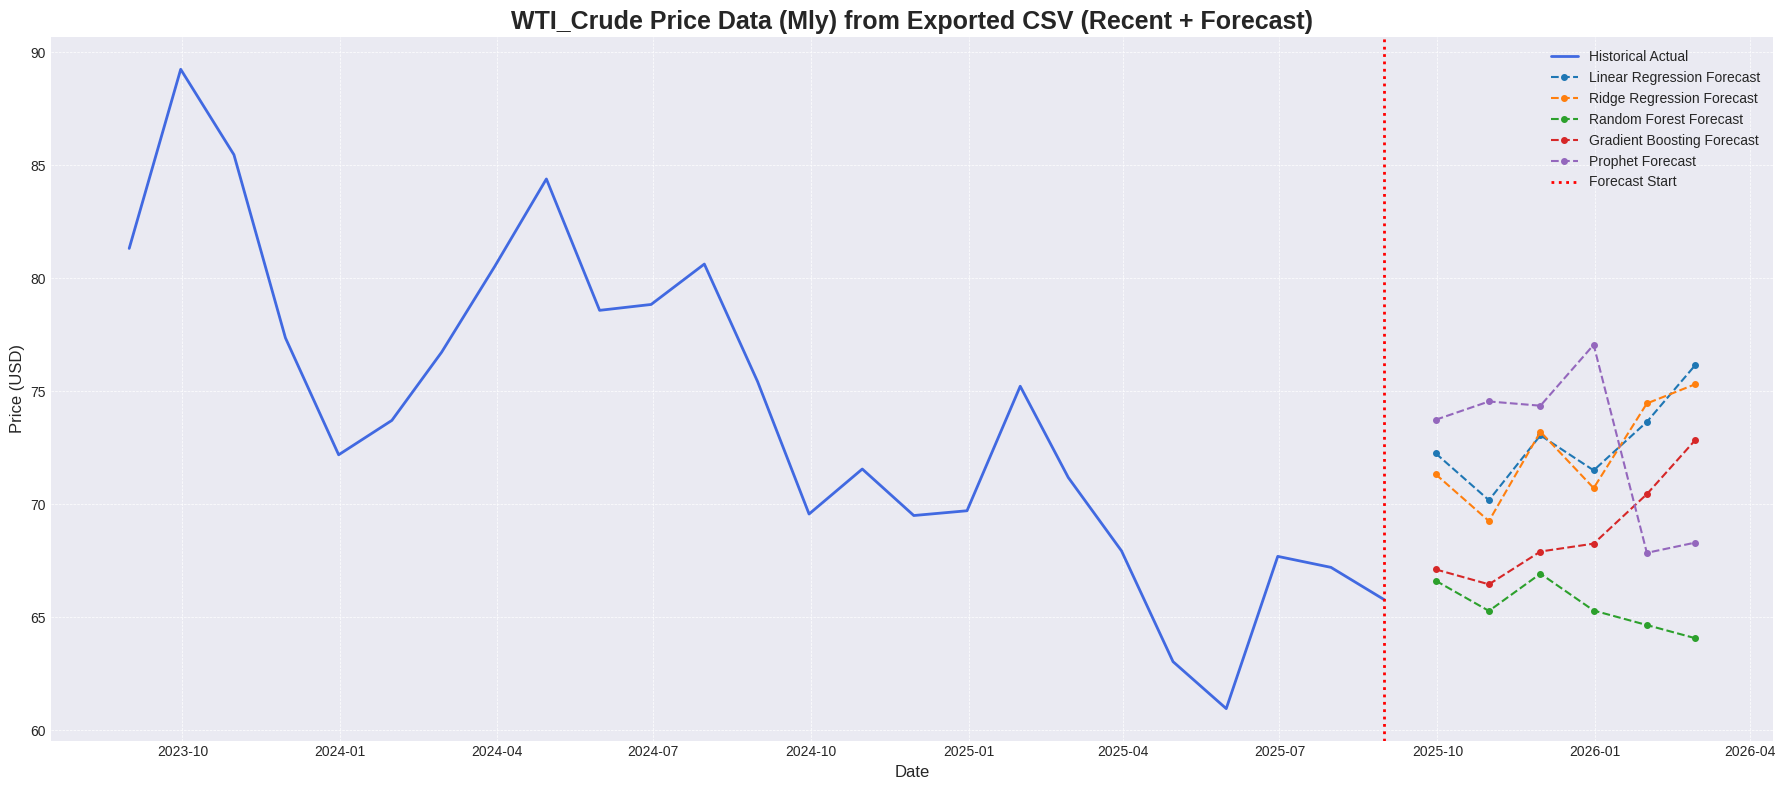

In [ ]:
# Visualize the exported data from the combined CSV (using the existing file)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the combined data CSV (assuming the previous export was successful for the current frequency)
csv_filename = f'combined_oil_price_data_{resample_frequency}.csv' # Use the current frequency
try:
    combined_df = pd.read_csv(csv_filename)
    combined_df['Date'] = pd.to_datetime(combined_df['Date'])

    print(f"Successfully loaded '{csv_filename}' for visualization.")
    display(combined_df.head())

    # Separate data types for plotting
    historical_actuals = combined_df[combined_df['DataType'] == 'Historical Actual'].copy()
    backtest_predictions = combined_df[combined_df['DataType'] == 'Backtest Prediction'].copy()
    future_forecast = combined_df[combined_df['DataType'] == 'Future Forecast'].copy()

    plt.style.use('seaborn-v0_8-darkgrid')
    plt.figure(figsize=(18, 8))

    # Determine the start date for recent historical data
    if not future_forecast.empty:
        forecast_start_date = historical_actuals['Date'].max()
        # Adjust the timedelta based on frequency for a reasonable view
        if resample_frequency == 'D':
            recent_history_start_date = forecast_start_date - pd.Timedelta(days=forecast_periods * 2) # Show ~2x forecast period
        elif resample_frequency == 'W':
            recent_history_start_date = forecast_start_date - pd.Timedelta(weeks=forecast_periods * 3) # Show ~3x forecast period
        elif resample_frequency == 'M':
             recent_history_start_date = forecast_start_date - pd.DateOffset(months=forecast_periods * 4) # Show ~4x forecast period offset
        else:
             recent_history_start_date = historical_actuals['Date'].min() # Default to all if frequency is unknown

        historical_actuals_recent = historical_actuals[historical_actuals['Date'] >= recent_history_start_date].copy()
    else:
        # If no future forecast, just plot all historical data
        historical_actuals_recent = historical_actuals.copy()


    # Plot Historical Actuals (Recent)
    plt.plot(historical_actuals_recent['Date'], historical_actuals_recent['Value'], label='Historical Actual', color='royalblue', linewidth=2)

    # Plot Backtest Predictions for ALL models within the recent historical range
    unique_models_backtest = backtest_predictions['Model'].unique() # Use a different variable name
    colors = sns.color_palette("husl", len(unique_models_backtest)) # Get distinct colors for each model
    color_map = dict(zip(unique_models_backtest, colors))

    for model_name in unique_models_backtest:
        model_backtest_data = backtest_predictions[(backtest_predictions['Model'] == model_name) &
                                                   (backtest_predictions['Date'] >= recent_history_start_date)].copy()
        if not model_backtest_data.empty:
             plt.plot(model_backtest_data['Date'], model_backtest_data['Value'], label=f'{model_name} Backtest', color=color_map[model_name], linestyle=':', linewidth=1.5)


    # Plot Future Forecast for ALL models in the future_forecast DataFrame
    if not future_forecast.empty:
        unique_models_forecast = future_forecast['Model'].unique()
        # Use a different color palette or continue the previous one if you want consistent colors
        forecast_colors = sns.color_palette("tab10", len(unique_models_forecast)) # Using a different palette for clarity
        forecast_color_map = dict(zip(unique_models_forecast, forecast_colors))

        for model_name in unique_models_forecast:
             model_forecast_data = future_forecast[future_forecast['Model'] == model_name].copy()
             plt.plot(model_forecast_data['Date'], model_forecast_data['Value'], label=f'{model_name} Forecast', color=forecast_color_map[model_name], linestyle='--', marker='o', markersize=4)

        # Add a vertical line at the forecast start date - only if there's a forecast
        forecast_start_date = historical_actuals['Date'].max()
        plt.axvline(forecast_start_date, color='red', linestyle=':', linewidth=2, label='Forecast Start')

    elif not historical_actuals.empty:
         # If no future forecast, add a line at the end of historical data
        forecast_start_date = historical_actuals['Date'].max()
        plt.axvline(forecast_start_date, color='red', linestyle=':', linewidth=2, label='End of Historical Data')


    plt.title(f'{target_col} Price Data ({resample_frequency}ly) from Exported CSV (Recent + Forecast)', fontsize=18, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price (USD)', fontsize=12)
    plt.legend(fontsize=10) # Reduced legend font size to accommodate more labels
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"Error: The file '{csv_filename}' was not found. Please ensure the export cell was run successfully.")
except Exception as e:
    print(f"An error occurred during visualization: {e}")

In [ ]:
# Export performance_metrics from Cell _yeJvqgjJDVx to a CSV file

# Check if performance_metrics is defined and is a DataFrame
if 'performance_metrics' in locals() and isinstance(performance_metrics, pd.DataFrame):
    metrics_filename = f'performance_metrics_Cell6_7_{resample_frequency}.csv' # Use a distinct name
    performance_metrics.to_csv(metrics_filename, index=True)
    print(f"✅ Exported performance metrics from Cell 6 & 7 to '{metrics_filename}'")
else:
    print("Error: performance_metrics DataFrame is not available from Cell 6 & 7 execution.")

✅ Exported performance metrics from Cell 6 & 7 to 'performance_metrics_Cell6_7_M.csv'
